#HW 10 CLUSTERING BUSINESS - Sara Arango Franco

### 1. get and prep your data.


In [1]:
# Important imports
import geopandas as gpd
import pandas as pd
import zipfile
import numpy as np
import matplotlib
%matplotlib inline

In [3]:
# Opening the business data, loading it and adding it to a single dataframe, df1
# Info from http://www.census.gov/econ/cbp/download/ 

fname = 'zbp'+'94'+'totals.zip' 
zf = zipfile.ZipFile(fname)
df1 = pd.read_csv(zf.open(fname.replace('.zip','.txt')))[['zip','est']]
df1.columns = [['zip','est'+'_'+'94']]

for yr in ['95','96','97','98','99','00','01','02','03','04','05','06','07','08','09','10','11','12','13']:
    fname = 'zbp'+yr+'totals.zip' 
    zf = zipfile.ZipFile(fname)
    try:
        nf = pd.read_csv(zf.open(fname.replace('.zip','.txt')))[['zip','est']]
    except KeyError:
        nf = pd.read_csv(zf.open(fname.replace('.zip','.txt')))[['ZIP','EST']]  
    nf.columns = [['zip','est'+'_'+yr]]
    df1 = pd.merge(df1,nf,on='zip')
df1.head()

,zip,est_94,est_95,est_96,est_97,est_98,est_99,est_00,est_01,est_02,...,est_04,est_05,est_06,est_07,est_08,est_09,est_10,est_11,est_12,est_13
0,1001,439,439,433,457,444,469,493,490,490,...,500,509,509,503,477,458,448,436,453,439
1,1002,450,467,487,500,490,558,563,587,566,...,584,589,582,596,584,571,570,558,572,572
2,1003,10,10,13,15,14,13,13,13,15,...,15,12,12,16,17,16,16,16,15,15
3,1004,47,48,47,41,31,35,48,37,23,...,43,31,30,20,18,18,21,19,16,16
4,1005,92,95,101,104,95,82,86,90,94,...,97,94,98,106,97,87,96,91,94,97


In [4]:
# Create timestamp series of years involved
import datetime
yrs = []
for yr in ['94','95','96','97','98','99']:
    yrs.append(datetime.date(int('19'+yr),1,1))
for yr in ['00','01','02','03','04','05','06','07','08','09','10','11','12','13']:
    yrs.append(datetime.date(int('20'+yr),1,1))

In [5]:
# Import geographical data for New York City
# Data from http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981

df2 = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
df2.columns = [           u'@id', u'BLDGpostalCode',       u'CTY_FIPS',
             u'OBJECTID',        u'PO_NAME',          u'STATE',
              u'ST_FIPS',     u'Shape_Area',     u'Shape_Leng',
              u'borough',       u'geometry',    'zip']
df2.columns
#data['geometry'][1]
#df2.head()

Index([           u'@id', u'BLDGpostalCode',       u'CTY_FIPS',
             u'OBJECTID',        u'PO_NAME',          u'STATE',
              u'ST_FIPS',     u'Shape_Area',     u'Shape_Leng',
              u'borough',       u'geometry',            u'zip'],
      dtype='object')

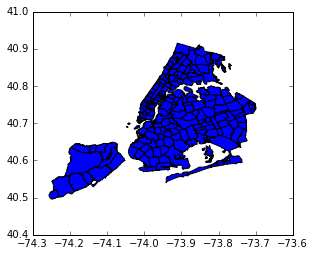

In [6]:
# A plot, just because

import matplotlib.pyplot as plt 
from descartes import PolygonPatch
#poly = 
BLUE = '#6699cc'
fig = plt.figure() 
ax = fig.gca() 
for i in df2['geometry']:
    ax.add_patch(PolygonPatch(i) )
ax.axis('scaled')
plt.show()

In [7]:
# Creating single data frame only for New York
df2['zip'] = df2['zip'].astype(float)
df3 = pd.merge(df1,df2,on="zip")

### 2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers) 

In [8]:
# Polishing, only getting establishments against zip
df3.index = df3.zip
data = df3[df3.columns[1:21]]
data.head()

,est_94,est_95,est_96,est_97,est_98,est_99,est_00,est_01,est_02,est_03,est_04,est_05,est_06,est_07,est_08,est_09,est_10,est_11,est_12,est_13
zip,,,,,,,,,,,,,,,,,,,,
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479
10004,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,1283,1260,1311,1370,1376,1379,1398,1404,1442,1479


In [85]:
import random
random.seed(2015)
from scipy.cluster.vq import kmeans2
nk = 6
ts=[]
groups = []
establishments = data.as_matrix().astype(float)
for i in range(0,establishments.shape[0]):
    establishments[i,:] = ((establishments[i,:] - np.mean(establishments[i,:]))/np.std(establishments[i,:]))
for j in range(0,establishments.shape[1]):
    cluster_centroids, closest_centroids = kmeans2(establishments[:,j], nk, iter=1)
    groups.append(closest_centroids)
    ts.append(cluster_centroids)

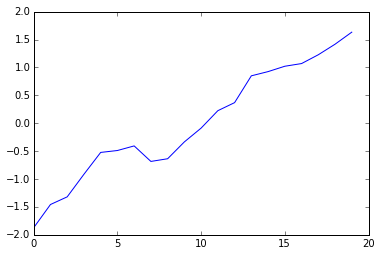

In [11]:
plt.plot(establishments[2,:])

### 3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).


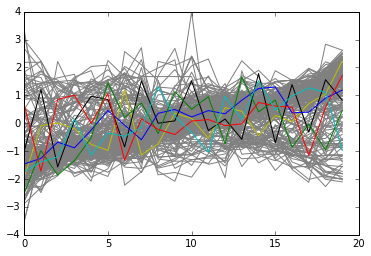

In [86]:
plt.plot(establishments.T,c='gray');
for j in range(0,nk):
    plt.plot([i[j] for i in ts])

### 4. Use another clustering algorithm (of your choice)


In [13]:
from sklearn.cluster import AgglomerativeClustering
groups_ag = []
ts = []
for j in range(0,establishments.shape[1]):
    hola = establishments[:,j]    
    cluster_centroids_ag = AgglomerativeClustering(n_clusters=nk,  compute_full_tree=True).fit(hola[:, np.newaxis])
    closest_centroids_ag = cluster_centroids_ag.labels_
    groups_ag.append(closest_centroids_ag)
    ts_ag.append(cluster_centroids_ag)

In [14]:
def getCentroid(points):
    #print points[:,0], np.nanmean(points[:,0])
    return np.nanmean(points)

In [16]:
centroids=[]
for j in range(0,establishments.shape[1]):
    ces=[]    
    for i in np.unique(groups_ag):
        ces.append(getCentroid(establishments[groups_ag[j] == i,j]))
    centroids.append(ces)

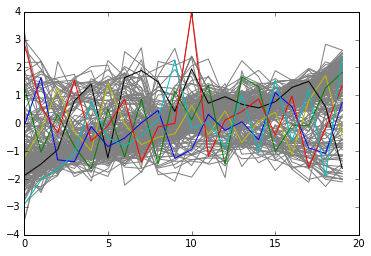

In [87]:
plt.plot(establishments.T,c='gray');
for j in range(0,nk):
    plt.plot([i[j] for i in centroids])

### 5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters


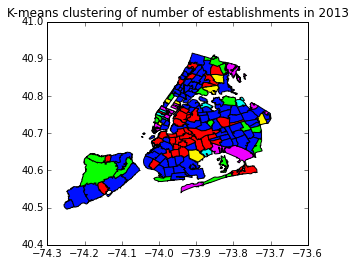

In [94]:
cc = pd.Series(groups[19])
my_cmap = matplotlib.cm.hsv(np.linspace(0,1,max(cc.values+2)))
fig = plt.figure() 
ax = fig.gca() 
for i in range(0,len(df3['geometry'])):
    ax.add_patch(PolygonPatch(df3['geometry'].iloc[i], fc = my_cmap[cc[i]]) )
ax.axis('scaled')
plt.title('K-means clustering of number of establishments in 2013')
plt.show()

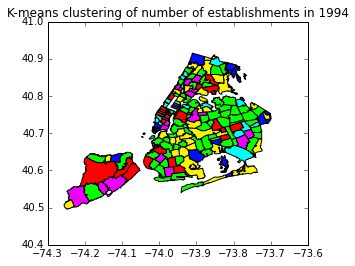

In [95]:
cc = pd.Series(groups[0])
my_cmap = matplotlib.cm.hsv(np.linspace(0,1,max(cc.values+2)))
fig = plt.figure() 
ax = fig.gca() 
for i in range(0,len(df3['geometry'])):
    ax.add_patch(PolygonPatch(df3['geometry'].iloc[i], fc = my_cmap[cc[i]]) )
ax.axis('scaled')
plt.title('K-means clustering of number of establishments in 1994')
plt.show()

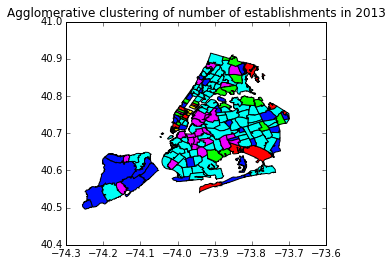

In [96]:
cc = pd.Series(groups_ag[19])
my_cmap = matplotlib.cm.hsv(np.linspace(0,1,max(cc.values+2)))
fig = plt.figure() 
ax = fig.gca() 
for i in range(0,len(df3['geometry'])):
    ax.add_patch(PolygonPatch(df3['geometry'].iloc[i], fc = my_cmap[cc[i]]) )
ax.axis('scaled')
plt.title('Agglomerative clustering of number of establishments in 2013')
plt.show()

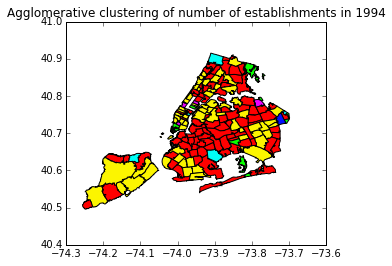

In [97]:
cc = pd.Series(groups_ag[0])
my_cmap = matplotlib.cm.hsv(np.linspace(0,1,max(cc.values+2)))
fig = plt.figure() 
ax = fig.gca() 
for i in range(0,len(df3['geometry'])):
    ax.add_patch(PolygonPatch(df3['geometry'].iloc[i], fc = my_cmap[cc[i]]) )
ax.axis('scaled')
plt.title('Agglomerative clustering of number of establishments in 1994')
plt.show()

### 6. Compare the results of the 2 algorithms

- They both identify important features, such as the airports
- They both identify northern Brooklyn + Southern Queens as a different area
- They both make (different) distinctions for areas that area clearly different from the citizen's experience: upper east and west side, lower east side, downtown Manhattan, etc.
- They both bring out areas of interest, such as Williamnsburg and Brooklyn Heights.

### 7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator.

- It is mportant to normalize against some important variable, such as population or, even better, area, since in this case population can distort the data. If we were to normalize against the area of each zip code, we could have a better indicator of where the businesses are really focusing.
- Tests would need to be performed changing the random seeds in many runs to check the robustness of the clusters.
- Other conclusions, above.